In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import seaborn as sns

from os.path import join

plt.style.use(["seaborn", "thesis"])

/home/jo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
plt.rc("figure", figsize=(8,4))

In [3]:
model_path = "../../thesis/models/DescriptorHomo/CC/"

# Molecules 

In [4]:
from SCFInitialGuess.utilities.dataset import ScreenedData

target = "P"
basis = "6-311++g**"

data = ScreenedData(r_max=10)

data.include(data_path = "../../thesis/dataset/MethanT/", postfix = "MethanT", target=target)

In [7]:
from SCFInitialGuess.utilities.dataset import ScreenedData

target = "P"

data = ScreenedData(r_max=10)

data.include(data_path = "../../thesis/dataset/MethanT/", postfix = "MethanT", target=target)
data.include(data_path = "../../thesis/dataset/MethanT2/", postfix = "MethanT2", target=target)
data.include(data_path = "../../thesis/dataset/MethanT3/", postfix = "MethanT3", target=target)
data.include(data_path = "../../thesis/dataset/MethanT4/", postfix = "MethanT4", target=target)

data.include(data_path = "../../thesis/dataset/EthanT/",  postfix = "EthanT", target=target)
data.include(data_path = "../../thesis/dataset/EthanT2/", postfix = "EthanT2", target=target)
data.include(data_path = "../../thesis/dataset/EthanT3/", postfix = "EthanT3", target=target)
data.include(data_path = "../../thesis/dataset/EthanT4/",  postfix = "EthanT4", target=target)
data.include(data_path = "../../thesis/dataset/EthanT5/",  postfix = "EthanT5", target=target)
data.include(data_path = "../../thesis/dataset/EthanT6/",  postfix = "EthanT6", target=target)

data.include(data_path = "../../thesis/dataset/EthenT/",  postfix = "EthenT", target=target)
data.include(data_path = "../../thesis/dataset/EthenT2/", postfix = "EthenT2", target=target)
data.include(data_path = "../../thesis/dataset/EthenT3/", postfix = "EthenT3", target=target)
data.include(data_path = "../../thesis/dataset/EthenT4/",  postfix = "EthenT4", target=target)
data.include(data_path = "../../thesis/dataset/EthenT5/",  postfix = "EthenT5", target=target)
data.include(data_path = "../../thesis/dataset/EthenT6/",  postfix = "EthenT6", target=target)


data.include(data_path = "../../thesis/dataset/EthinT/",  postfix = "EthinT", target=target)
data.include(data_path = "../../thesis/dataset/EthinT2/", postfix = "EthinT2", target=target)
data.include(data_path = "../../thesis/dataset/EthinT3/", postfix = "EthinT3", target=target)

#data.include(data_path = "../../dataset/QM9/", postfix = "QM9-300")

# Descriptor 

In [8]:
from SCFInitialGuess.descriptors.high_level import AtomicNumberWeighted
from SCFInitialGuess.descriptors.cutoffs import BehlerCutoff1
from SCFInitialGuess.descriptors.models import RADIAL_GAUSSIAN_MODELS, make_uniform
from SCFInitialGuess.descriptors.coordinate_descriptors import \
    Gaussians, SPHAngularDescriptor
import pickle

model = make_uniform(25, 5, eta_max=60, eta_min=20)

descriptor = AtomicNumberWeighted(
    Gaussians(*model),
    SPHAngularDescriptor(4),
    BehlerCutoff1(5)
)

pickle.dump(descriptor, open(model_path + "descriptor.dump", "wb"))
    
descriptor.radial_descriptor.number_of_descriptors, descriptor.angular_descriptor.number_of_descriptors, descriptor.number_of_descriptors

(25, 50, 75)

# Package Dataset 

In [9]:
from SCFInitialGuess.utilities.dataset import make_block_dataset, extract_HOMO_block_dataset_pairs

dataset = make_block_dataset(
    descriptor,
    data.molecules,
    data.T,
    "C",
    extract_HOMO_block_dataset_pairs
)

np.save(model_path + "normalisation.npy", (dataset.x_mean, dataset.x_std))


In [10]:
len(dataset.training[0]), len(dataset.validation[0]), len(dataset.testing[0]), 

(5459, 1370, 1718)

In [11]:
from SCFInitialGuess.utilities.constants import number_of_basis_functions as N_BASIS

species = "C"
dim = N_BASIS[basis][species]
dim_triu = dim * (dim + 1) // 2

# NN Utils 

In [12]:
#keras.backend.clear_session()

#activation = "elu"
#learning_rate = 1e-5

intializer = keras.initializers.TruncatedNormal(mean=0.0, stddev=0.01)

def make_model(
        structure, 
        input_dim, 
        output_dim,
        activation="elu", 
        learning_rate=1e-3
    ):

    model = keras.Sequential()

    # input layer
    model.add(keras.layers.Dense(
        structure[0], 
        activation=activation, 
        input_dim=input_dim, 
        kernel_initializer=intializer
    ))

    for layer in structure[1:]:
        model.add(keras.layers.Dense(
            layer, 
            activation=activation, 
            kernel_initializer=intializer, 
            #bias_initializer='zeros',
            kernel_regularizer=keras.regularizers.l2(5e-3)
        ))

    #output
    model.add(keras.layers.Dense(output_dim))

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate), 
        loss='MSE', 
        metrics=['mse']
    )
    
    return model



In [13]:

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_mean_squared_error", 
    min_delta=1e-8, 
    patience=20, 
    verbose=1
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_mean_squared_error', 
    factor=0.1, 
    patience=3, 
    verbose=1, 
    mode='auto', 
    min_delta=1e-6, 
    cooldown=2, 
    min_lr=1e-10
)


epochs = 1000


def train_model(model, dataset, filepath=None, learning_rate=1e-4, log_dir=None):

    if not log_dir is None:
        tensorboard = keras.callbacks.TensorBoard(
            log_dir=log_dir, 
            histogram_freq=0, 
            batch_size=32, 
            #update_freq='epoch'
        )
    
    if not filepath is None:
        checkpoint = keras.callbacks.ModelCheckpoint(
            filepath, 
            monitor='val_mean_squared_error', 
            verbose=1, 
            save_best_only=True, 
            save_weights_only=False, 
            mode='auto', 
            period=1
        )
    
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    
    train, validation = [], []
    while True:
        keras.backend.set_value(model.optimizer.lr, learning_rate)
            
        history = model.fit(
            x = dataset.training[0],
            y = dataset.training[1],
            epochs=epochs,
            shuffle=True,
            validation_data=dataset.validation, 
            verbose=1, 
            callbacks=[
                early_stopping, 
                reduce_lr,
                checkpoint,
                #tensorboard
            ]
        )
            
        
        #error.append(model.evaluate(
        #    dataset.testing[0], 
        #    dataset.testing[1], 
        #    verbose=1
        #)[1])
    
    return error
    

# Training 

In [14]:
dataset.training[0].shape, dataset.training[1].shape

((5459, 150), (5459, 484))

In [15]:
descriptor.number_of_descriptors, dim**2

(75, 484)

In [16]:
structure = [100, 70]

In [17]:
keras.backend.clear_session()

In [18]:
model = make_model(
    structure=structure,
    input_dim=descriptor.number_of_descriptors * 2,
    output_dim=dim**2,
    
)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               15100     
_________________________________________________________________
dense_1 (Dense)              (None, 70)                7070      
_________________________________________________________________
dense_2 (Dense)              (None, 484)               34364     
Total params: 56,534
Trainable params: 56,534
Non-trainable params: 0
_________________________________________________________________


Train on 5459 samples, validate on 1370 samples
Epoch 1/1000
5459/5459 [==============================] - 2s 314us/step - loss: 7.7765e-04 - mean_squared_error: 6.5083e-04 - val_loss: 6.0046e-04 - val_mean_squared_error: 5.5889e-04

Epoch 00001: val_mean_squared_error improved from inf to 0.00056, saving model to ../../thesis/models/DescriptorHomo/CC/model.h5
Epoch 2/1000
5459/5459 [==============================] - 0s 75us/step - loss: 5.3356e-04 - mean_squared_error: 4.8492e-04 - val_loss: 5.6671e-04 - val_mean_squared_error: 5.1623e-04

Epoch 00002: val_mean_squared_error improved from 0.00056 to 0.00052, saving model to ../../thesis/models/DescriptorHomo/CC/model.h5
Epoch 3/1000
5459/5459 [==============================] - 0s 73us/step - loss: 4.8372e-04 - mean_squared_error: 4.3263e-04 - val_loss: 5.6995e-04 - val_mean_squared_error: 4.9781e-04

Epoch 00003: val_mean_squared_error improved from 0.00052 to 0.00050, saving model to ../../thesis/models/DescriptorHomo/CC/model.h5
Epoc

5459/5459 [==============================] - 0s 82us/step - loss: 3.4923e-04 - mean_squared_error: 3.1866e-04 - val_loss: 4.4587e-04 - val_mean_squared_error: 4.1532e-04

Epoch 00029: val_mean_squared_error did not improve from 0.00042
Epoch 30/1000
5459/5459 [==============================] - 0s 79us/step - loss: 3.4922e-04 - mean_squared_error: 3.1867e-04 - val_loss: 4.4586e-04 - val_mean_squared_error: 4.1531e-04

Epoch 00030: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.

Epoch 00030: val_mean_squared_error did not improve from 0.00042
Epoch 31/1000
5459/5459 [==============================] - 0s 79us/step - loss: 3.4921e-04 - mean_squared_error: 3.1866e-04 - val_loss: 4.4586e-04 - val_mean_squared_error: 4.1531e-04

Epoch 00031: val_mean_squared_error did not improve from 0.00042
Epoch 32/1000
5459/5459 [==============================] - 0s 79us/step - loss: 3.4921e-04 - mean_squared_error: 3.1866e-04 - val_loss: 4.4586e-04 - val_mean_squared_error: 4.1531e-04


Epoch 00018: val_mean_squared_error improved from 0.00040 to 0.00040, saving model to ../../thesis/models/DescriptorHomo/CC/model.h5
Epoch 19/1000
5459/5459 [==============================] - 0s 64us/step - loss: 3.2059e-04 - mean_squared_error: 2.8862e-04 - val_loss: 4.2896e-04 - val_mean_squared_error: 3.9711e-04

Epoch 00019: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00019: val_mean_squared_error improved from 0.00040 to 0.00040, saving model to ../../thesis/models/DescriptorHomo/CC/model.h5
Epoch 20/1000
5459/5459 [==============================] - 0s 69us/step - loss: 3.1627e-04 - mean_squared_error: 2.8519e-04 - val_loss: 4.2556e-04 - val_mean_squared_error: 3.9503e-04

Epoch 00020: val_mean_squared_error improved from 0.00040 to 0.00040, saving model to ../../thesis/models/DescriptorHomo/CC/model.h5
Epoch 21/1000
5459/5459 [==============================] - 0s 65us/step - loss: 3.1496e-04 - mean_squared_error: 2.8445e-04 - val_loss: 4.2526e-04 -

5459/5459 [==============================] - 0s 63us/step - loss: 3.1359e-04 - mean_squared_error: 2.8330e-04 - val_loss: 4.2503e-04 - val_mean_squared_error: 3.9475e-04

Epoch 00047: ReduceLROnPlateau reducing learning rate to 1e-10.

Epoch 00047: val_mean_squared_error did not improve from 0.00039
Epoch 00047: early stopping
Train on 5459 samples, validate on 1370 samples
Epoch 1/1000
5459/5459 [==============================] - 0s 64us/step - loss: 3.9413e-04 - mean_squared_error: 3.3391e-04 - val_loss: 4.9700e-04 - val_mean_squared_error: 4.4086e-04

Epoch 00001: val_mean_squared_error did not improve from 0.00039
Epoch 2/1000
5459/5459 [==============================] - 0s 63us/step - loss: 3.7622e-04 - mean_squared_error: 3.2235e-04 - val_loss: 4.8477e-04 - val_mean_squared_error: 4.3305e-04

Epoch 00002: val_mean_squared_error did not improve from 0.00039
Epoch 3/1000
5459/5459 [==============================] - 0s 63us/step - loss: 3.7378e-04 - mean_squared_error: 3.2119e-04 - 

5459/5459 [==============================] - 1s 104us/step - loss: 3.0152e-04 - mean_squared_error: 2.7032e-04 - val_loss: 4.2130e-04 - val_mean_squared_error: 3.9009e-04

Epoch 00029: val_mean_squared_error did not improve from 0.00039
Epoch 30/1000
5459/5459 [==============================] - 1s 114us/step - loss: 3.0152e-04 - mean_squared_error: 2.7032e-04 - val_loss: 4.2130e-04 - val_mean_squared_error: 3.9009e-04

Epoch 00030: val_mean_squared_error did not improve from 0.00039
Epoch 31/1000
5459/5459 [==============================] - 1s 174us/step - loss: 3.0152e-04 - mean_squared_error: 2.7032e-04 - val_loss: 4.2130e-04 - val_mean_squared_error: 3.9009e-04

Epoch 00031: val_mean_squared_error did not improve from 0.00039
Epoch 32/1000
5459/5459 [==============================] - 1s 169us/step - loss: 3.0152e-04 - mean_squared_error: 2.7032e-04 - val_loss: 4.2130e-04 - val_mean_squared_error: 3.9009e-04

Epoch 00032: ReduceLROnPlateau reducing learning rate to 1.000000082740371e

5459/5459 [==============================] - 1s 103us/step - loss: 2.9038e-04 - mean_squared_error: 2.6031e-04 - val_loss: 4.1834e-04 - val_mean_squared_error: 3.8827e-04

Epoch 00024: val_mean_squared_error improved from 0.00039 to 0.00039, saving model to ../../thesis/models/DescriptorHomo/CC/model.h5
Epoch 25/1000
5459/5459 [==============================] - 1s 106us/step - loss: 2.9038e-04 - mean_squared_error: 2.6031e-04 - val_loss: 4.1834e-04 - val_mean_squared_error: 3.8827e-04

Epoch 00025: val_mean_squared_error improved from 0.00039 to 0.00039, saving model to ../../thesis/models/DescriptorHomo/CC/model.h5
Epoch 26/1000
5459/5459 [==============================] - 0s 80us/step - loss: 2.9038e-04 - mean_squared_error: 2.6031e-04 - val_loss: 4.1834e-04 - val_mean_squared_error: 3.8827e-04

Epoch 00026: val_mean_squared_error did not improve from 0.00039
Epoch 27/1000
5459/5459 [==============================] - 1s 92us/step - loss: 2.9038e-04 - mean_squared_error: 2.6031e-04 - 

5459/5459 [==============================] - 1s 142us/step - loss: 2.9496e-04 - mean_squared_error: 2.5966e-04 - val_loss: 4.2928e-04 - val_mean_squared_error: 3.9471e-04

Epoch 00009: val_mean_squared_error did not improve from 0.00039
Epoch 10/1000
5459/5459 [==============================] - 1s 97us/step - loss: 2.9026e-04 - mean_squared_error: 2.5537e-04 - val_loss: 4.2003e-04 - val_mean_squared_error: 3.8689e-04

Epoch 00010: val_mean_squared_error improved from 0.00039 to 0.00039, saving model to ../../thesis/models/DescriptorHomo/CC/model.h5
Epoch 11/1000
5459/5459 [==============================] - 0s 87us/step - loss: 2.8917e-04 - mean_squared_error: 2.5575e-04 - val_loss: 4.2773e-04 - val_mean_squared_error: 3.9359e-04

Epoch 00011: val_mean_squared_error did not improve from 0.00039
Epoch 12/1000
5459/5459 [==============================] - 1s 97us/step - loss: 2.8760e-04 - mean_squared_error: 2.5425e-04 - val_loss: 4.2159e-04 - val_mean_squared_error: 3.8907e-04

Epoch 0001

5459/5459 [==============================] - 0s 90us/step - loss: 2.8085e-04 - mean_squared_error: 2.4748e-04 - val_loss: 4.2734e-04 - val_mean_squared_error: 3.9366e-04

Epoch 00009: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00009: val_mean_squared_error did not improve from 0.00039
Epoch 10/1000
5459/5459 [==============================] - 1s 96us/step - loss: 2.7716e-04 - mean_squared_error: 2.4419e-04 - val_loss: 4.2363e-04 - val_mean_squared_error: 3.9121e-04

Epoch 00010: val_mean_squared_error did not improve from 0.00039
Epoch 11/1000
5459/5459 [==============================] - 1s 107us/step - loss: 2.7570e-04 - mean_squared_error: 2.4353e-04 - val_loss: 4.2244e-04 - val_mean_squared_error: 3.9018e-04

Epoch 00011: val_mean_squared_error did not improve from 0.00039
Epoch 12/1000
5459/5459 [==============================] - 1s 132us/step - loss: 2.7544e-04 - mean_squared_error: 2.4317e-04 - val_loss: 4.2246e-04 - val_mean_squared_error: 3.9026e

5459/5459 [==============================] - 1s 102us/step - loss: 3.2524e-04 - mean_squared_error: 2.7625e-04 - val_loss: 4.7090e-04 - val_mean_squared_error: 4.2228e-04

Epoch 00006: val_mean_squared_error did not improve from 0.00039
Epoch 7/1000
5459/5459 [==============================] - 1s 113us/step - loss: 3.2272e-04 - mean_squared_error: 2.7412e-04 - val_loss: 4.6219e-04 - val_mean_squared_error: 4.1279e-04

Epoch 00007: val_mean_squared_error did not improve from 0.00039
Epoch 8/1000
5459/5459 [==============================] - 1s 114us/step - loss: 3.2578e-04 - mean_squared_error: 2.7526e-04 - val_loss: 4.8474e-04 - val_mean_squared_error: 4.3780e-04

Epoch 00008: val_mean_squared_error did not improve from 0.00039
Epoch 9/1000
5459/5459 [==============================] - 1s 108us/step - loss: 3.2401e-04 - mean_squared_error: 2.7502e-04 - val_loss: 4.7386e-04 - val_mean_squared_error: 4.2823e-04

Epoch 00009: val_mean_squared_error did not improve from 0.00039
Epoch 10/1000

5459/5459 [==============================] - 1s 116us/step - loss: 2.6416e-04 - mean_squared_error: 2.3185e-04 - val_loss: 4.2518e-04 - val_mean_squared_error: 3.9286e-04

Epoch 00036: val_mean_squared_error did not improve from 0.00039
Epoch 37/1000
5459/5459 [==============================] - 1s 120us/step - loss: 2.6416e-04 - mean_squared_error: 2.3185e-04 - val_loss: 4.2518e-04 - val_mean_squared_error: 3.9286e-04

Epoch 00037: val_mean_squared_error did not improve from 0.00039
Epoch 00037: early stopping
Train on 5459 samples, validate on 1370 samples
Epoch 1/1000
5459/5459 [==============================] - 1s 110us/step - loss: 3.4709e-04 - mean_squared_error: 2.8562e-04 - val_loss: 4.9315e-04 - val_mean_squared_error: 4.3115e-04

Epoch 00001: val_mean_squared_error did not improve from 0.00039
Epoch 2/1000
5459/5459 [==============================] - 1s 130us/step - loss: 3.3094e-04 - mean_squared_error: 2.7601e-04 - val_loss: 5.2078e-04 - val_mean_squared_error: 4.6180e-04

E

5459/5459 [==============================] - 1s 120us/step - loss: 2.5549e-04 - mean_squared_error: 2.2324e-04 - val_loss: 4.2465e-04 - val_mean_squared_error: 3.9240e-04

Epoch 00030: val_mean_squared_error did not improve from 0.00039
Epoch 31/1000
5459/5459 [==============================] - 1s 129us/step - loss: 2.5549e-04 - mean_squared_error: 2.2324e-04 - val_loss: 4.2465e-04 - val_mean_squared_error: 3.9240e-04

Epoch 00031: val_mean_squared_error did not improve from 0.00039
Epoch 32/1000
5459/5459 [==============================] - 1s 142us/step - loss: 2.5549e-04 - mean_squared_error: 2.2324e-04 - val_loss: 4.2465e-04 - val_mean_squared_error: 3.9240e-04

Epoch 00032: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-09.

Epoch 00032: val_mean_squared_error did not improve from 0.00039
Epoch 33/1000
5459/5459 [==============================] - 1s 113us/step - loss: 2.5549e-04 - mean_squared_error: 2.2324e-04 - val_loss: 4.2465e-04 - val_mean_squared_error: 3.9240


Epoch 00027: val_mean_squared_error did not improve from 0.00039
Epoch 28/1000
5459/5459 [==============================] - 1s 141us/step - loss: 2.5093e-04 - mean_squared_error: 2.1773e-04 - val_loss: 4.2605e-04 - val_mean_squared_error: 3.9285e-04

Epoch 00028: val_mean_squared_error did not improve from 0.00039
Epoch 29/1000
5459/5459 [==============================] - 1s 137us/step - loss: 2.5093e-04 - mean_squared_error: 2.1773e-04 - val_loss: 4.2605e-04 - val_mean_squared_error: 3.9285e-04

Epoch 00029: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-09.

Epoch 00029: val_mean_squared_error did not improve from 0.00039
Epoch 30/1000
5459/5459 [==============================] - 1s 116us/step - loss: 2.5093e-04 - mean_squared_error: 2.1773e-04 - val_loss: 4.2605e-04 - val_mean_squared_error: 3.9285e-04

Epoch 00030: val_mean_squared_error did not improve from 0.00039
Epoch 31/1000
5459/5459 [==============================] - 1s 115us/step - loss: 2.5093e-04 - mean_s

5459/5459 [==============================] - 1s 140us/step - loss: 2.4890e-04 - mean_squared_error: 2.1447e-04 - val_loss: 4.2816e-04 - val_mean_squared_error: 3.9373e-04

Epoch 00027: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-09.

Epoch 00027: val_mean_squared_error did not improve from 0.00039
Epoch 28/1000
5459/5459 [==============================] - 1s 145us/step - loss: 2.4890e-04 - mean_squared_error: 2.1447e-04 - val_loss: 4.2816e-04 - val_mean_squared_error: 3.9373e-04

Epoch 00028: val_mean_squared_error did not improve from 0.00039
Epoch 29/1000
5459/5459 [==============================] - 1s 140us/step - loss: 2.4890e-04 - mean_squared_error: 2.1447e-04 - val_loss: 4.2816e-04 - val_mean_squared_error: 3.9373e-04

Epoch 00029: val_mean_squared_error did not improve from 0.00039
Epoch 30/1000
5459/5459 [==============================] - 1s 139us/step - loss: 2.4890e-04 - mean_squared_error: 2.1447e-04 - val_loss: 4.2816e-04 - val_mean_squared_error: 3.9373

5459/5459 [==============================] - 1s 194us/step - loss: 2.4334e-04 - mean_squared_error: 2.0980e-04 - val_loss: 4.2681e-04 - val_mean_squared_error: 3.9327e-04

Epoch 00025: val_mean_squared_error did not improve from 0.00039
Epoch 26/1000
5459/5459 [==============================] - 1s 190us/step - loss: 2.4334e-04 - mean_squared_error: 2.0980e-04 - val_loss: 4.2681e-04 - val_mean_squared_error: 3.9327e-04

Epoch 00026: val_mean_squared_error did not improve from 0.00039
Epoch 27/1000
5459/5459 [==============================] - 1s 186us/step - loss: 2.4334e-04 - mean_squared_error: 2.0980e-04 - val_loss: 4.2681e-04 - val_mean_squared_error: 3.9327e-04

Epoch 00027: val_mean_squared_error did not improve from 0.00039
Epoch 28/1000
5459/5459 [==============================] - 1s 197us/step - loss: 2.4334e-04 - mean_squared_error: 2.0980e-04 - val_loss: 4.2681e-04 - val_mean_squared_error: 3.9327e-04

Epoch 00028: ReduceLROnPlateau reducing learning rate to 1.000000082740371e

5459/5459 [==============================] - 1s 130us/step - loss: 2.3731e-04 - mean_squared_error: 2.0482e-04 - val_loss: 4.2579e-04 - val_mean_squared_error: 3.9330e-04

Epoch 00027: val_mean_squared_error did not improve from 0.00039
Epoch 28/1000
5459/5459 [==============================] - 1s 114us/step - loss: 2.3731e-04 - mean_squared_error: 2.0482e-04 - val_loss: 4.2578e-04 - val_mean_squared_error: 3.9329e-04

Epoch 00028: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.

Epoch 00028: val_mean_squared_error did not improve from 0.00039
Epoch 29/1000
5459/5459 [==============================] - 1s 113us/step - loss: 2.3730e-04 - mean_squared_error: 2.0481e-04 - val_loss: 4.2578e-04 - val_mean_squared_error: 3.9329e-04

Epoch 00029: val_mean_squared_error did not improve from 0.00039
Epoch 30/1000
5459/5459 [==============================] - 1s 114us/step - loss: 2.3730e-04 - mean_squared_error: 2.0481e-04 - val_loss: 4.2578e-04 - val_mean_squared_error: 3.9329

5459/5459 [==============================] - 1s 185us/step - loss: 2.3720e-04 - mean_squared_error: 2.0255e-04 - val_loss: 4.2913e-04 - val_mean_squared_error: 3.9448e-04

Epoch 00025: val_mean_squared_error did not improve from 0.00039
Epoch 26/1000
5459/5459 [==============================] - 1s 226us/step - loss: 2.3718e-04 - mean_squared_error: 2.0256e-04 - val_loss: 4.2904e-04 - val_mean_squared_error: 3.9441e-04

Epoch 00026: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 00026: val_mean_squared_error did not improve from 0.00039
Epoch 27/1000
5459/5459 [==============================] - 2s 279us/step - loss: 2.3709e-04 - mean_squared_error: 2.0246e-04 - val_loss: 4.2904e-04 - val_mean_squared_error: 3.9441e-04

Epoch 00027: val_mean_squared_error did not improve from 0.00039
Epoch 28/1000
5459/5459 [==============================] - 2s 334us/step - loss: 2.3708e-04 - mean_squared_error: 2.0246e-04 - val_loss: 4.2905e-04 - val_mean_squared_error: 3.944

KeyboardInterrupt: 

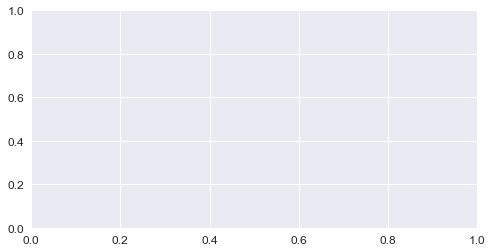

In [19]:
#i+=1
train_model(
    model, 
    dataset, 
    model_path + "model.h5",
    learning_rate=1e-3,
    #log_dir=None#"./logs/H/" + name + "_" + "x".join(list(map(str, structure))) + "_" + str(i)
)